In [2]:
!apt-get update
!pip install -q pmdarima

Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:2 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:6 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:7 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease [3,626 B]
Hit:9 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:11 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:12 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic InRelease [15.4 kB]
Get:13 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ Packages [92.1 kB]
Get:14 http://security.ubuntu.com/ubuntu bionic-security/main amd64 Packa

In [0]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize']=10,6
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [0]:
class pricedata:
  __data = pd.DataFrame()
  __train_data = []
  __test_data = []
  __model = None
  def __init__(self):
    print('instance created')
    self.__loaddata()
    self.__preprocess()
    self.__visualize()
    self.__checkstationarity()
    if self.__checkwithadftest() == True:
      self.__createmodel()
      self.__forecast()
    else:
      print('model not stationarized. so not building any model')
  
  def __loaddata(self):
    print('loading data from aaba.us.csv')
    self.__data = pd.read_csv('aaba.us.csv',index_col='Date',parse_dates=True,date_parser=lambda dt : pd.datetime.strptime(dt,'%Y-%m-%d'))

  def __preprocess(self):
    print('checking null values and making null to 0')
    print(self.__data.isnull().sum())
    self.__data = self.__data.fillna(0)

  def __checkwithadftest(self):
    try:
      print('performing dickey fuller test')
      done = False
      data = self.__data['Close']
      maxcount = 0
      while maxcount <10:
        maxcount +=1
        adft = adfuller(data,autolag='AIC')
        output = pd.Series(adft[0:4],index=['Test statistics','P-value','no. of lags', 'no. of observations'])
        for key, value in adft[4].items():
          output['critical value %s' %key]=value
        print(str(maxcount),'-->', str(output['P-value']))
        if output['P-value'] < 0.05:
          print('data became stationary')
          print(output)
          done = True
          self.__processeddata =data
          return done
        else:
          print('data is not yet stationary. using differencing')
          datadiff = self.__data['Close'].diff(maxcount).dropna()
          #print('data is not yet stationary. using log')
          #datadiff = np.log(data).dropna()

          data = datadiff
    except:
      print('****************exception*********************')
    return False


  def __checkstationarity(self):
    closeprice = self.__data['Close']
    
    rolmean = closeprice.rolling(12).mean()
    rolstd = closeprice.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(closeprice, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)

    #show decomposition
    print('inorder to make it stationary, we need to decompose it and remove trend and seasonality')
    result = seasonal_decompose(closeprice,model='multiplicative',freq=30)
    fig = plt.figure()  
    fig = result.plot()  
    fig.set_size_inches(16, 9)
    plt.show()
    
    print('null hypothesis says, its not stationary. if test statistic is > critical value (in 2 tailed approach lets say '\
          'if critical value is -X then test statistic should be >X or <-X to reject null hypo.) in p-value approch if '\
          ' p-value is < 0.05 (5%) then reject null hypo')
    print('we can make a series as stationary by 2 ways.')
    print('1.trending can be removed by taking log trasform. seasonality is removed by taking rolling avg (12 months).')
    print('2. differencing : we deduct the timeseries value with another timeseries formed by a lag')
    print('lets check with differencing')
    print('ARIMA vs SARIMA : ARIMA does not support data with seasonality, so we need to use SARIMA')
    
    #making stationary
    '''
    closeprice_log = np.log(closeprice)
    moving_avg = closeprice_log.rolling(12).mean()
    moving_std = closeprice_log.rolling(12).std()
    #plot graph
    plt.legend(loc='best')
    plt.plot(moving_avg,color='red',label='moving avg')
    plt.plot(moving_std,color='black',label='moving std')
    plt.legend()
    plt.show()
    '''
  
  def __createmodel(self):
    #df_log = np.log(self.__data['Close'])
    print('we do\'t use train_test_split to get train and test data, we take first 90% as train and remaing as test. key point is here its sequential')
    print('checking stationarity by doing log transform or  differencing is to determine whethere timeseries is stationary or not , we don\' use that tested'\
          'data for our model building')
    print('removing staionarity by log transform becoz we are using ARIMA')
    closeprice = np.log(self.__data['Close']).dropna()
    self.__train_data, self.__test_data = closeprice[3:int(len(closeprice)*0.9)], closeprice[int(len(closeprice)*0.9):]
    print('train data count' ,str(self.__train_data.count()))
    print('test data count' ,str(self.__test_data.count()))
    model_autoARIMA = auto_arima(self.__train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find             optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
    print(model_autoARIMA.summary())
    self.__model = ARIMA(self.__train_data,order=(3,1,0)).fit() # here we need to get params 
    print('model ready')
    print(self.__model.summary())
  
  def __forecast(self):
    print('forecasting')
    fc, se, conf = self.__model.forecast(544, alpha=0.05)  # 95% confidence
    fc_series = pd.Series(fc, index=self.__test_data.index)
    lower_series = pd.Series(conf[:, 0], index=self.__test_data.index)
    upper_series = pd.Series(conf[:, 1], index=self.__test_data.index)
    plt.figure(figsize=(12,5), dpi=100)
    plt.plot(self.__train_data, label='training',color = 'black')
    plt.plot(self.__test_data, color = 'blue', label='Actual Stock Price')
    plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
    plt.fill_between(lower_series.index, lower_series, upper_series, 
                    color='k', alpha=.10)
    plt.title('Altaba Inc. Stock Price Prediction')
    plt.xlabel='time'
    plt.ylabel='Actual Stock Price'
    plt.legend(loc='upper left', fontsize=8)
    plt.show()
  
  def __visualize(self):
    plt.figure(figsize=(10,6))
    plt.grid=True
    plt.xlabel='Dates'
    plt.ylabel='CLOSE PRICE'
    plt.plot(self.__data['Close'])
    plt.show()
    plt.close()



instance created
loading data from aaba.us.csv
checking null values and making null to 0
Open       0
High       0
Low        0
Close      0
Volume     0
OpenInt    0
dtype: int64


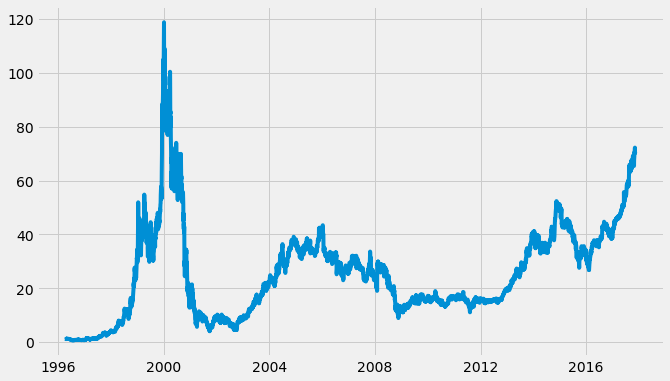

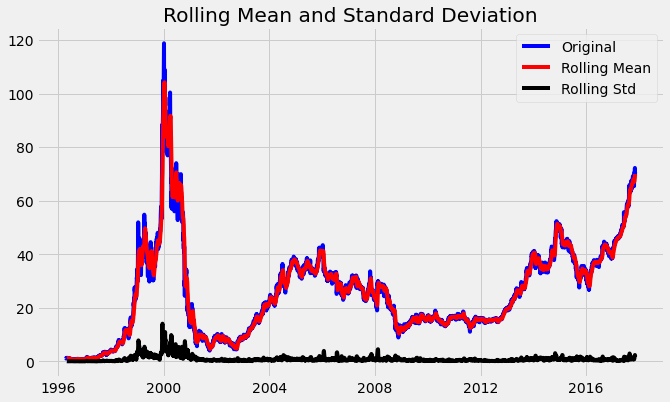

inorder to make it stationary, we need to decompose it and remove trend and seasonality


<Figure size 720x432 with 0 Axes>

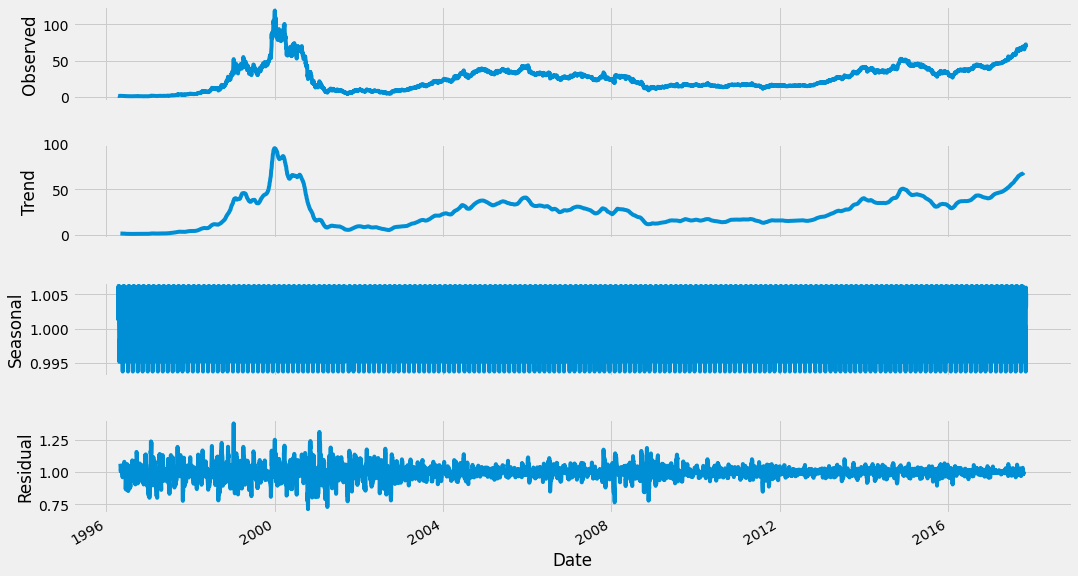

null hypothesis says, its not stationary. if test statistic is > critical value (in 2 tailed approach lets say if critical value is -X then test statistic should be >X or <-X to reject null hypo.) in p-value approch if  p-value is < 0.05 (5%) then reject null hypo
we can make a series as stationary by 2 ways.
1.trending can be removed by taking log trasform. seasonality is removed by taking rolling avg (12 months).
2. differencing : we deduct the timeseries value with another timeseries formed by a lag
lets check with differencing
ARIMA vs SARIMA : ARIMA does not support data with seasonality, so we need to use SARIMA
performing dickey fuller test
1 --> 0.25995005844232455
data is not yet stationary. using differencing
2 --> 6.521901945037599e-23
data became stationary
Test statistics       -1.232803e+01
P-value                6.521902e-23
no. of lags            3.300000e+01
no. of observations    5.399000e+03
critical value 1%     -3.431562e+00
critical value 5%     -2.862075e+00
crit

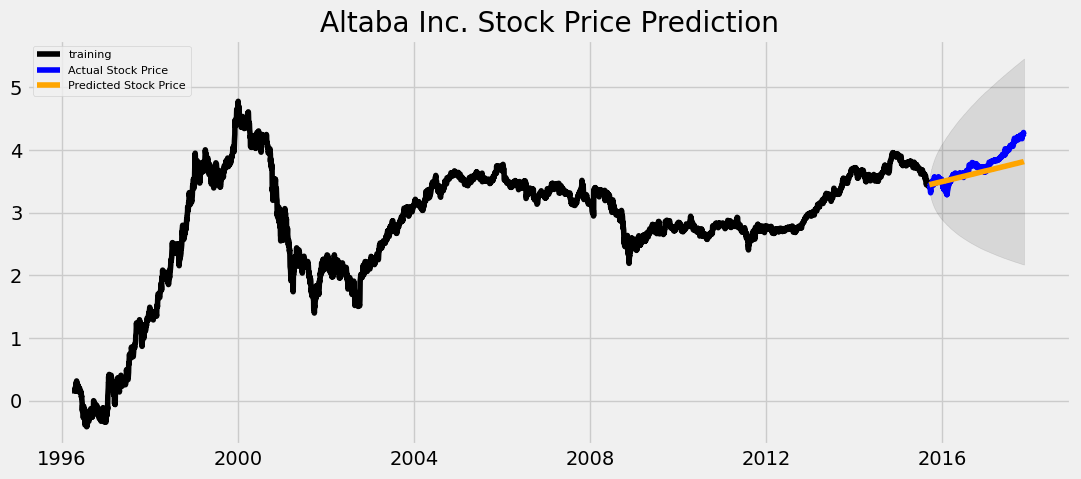

In [187]:
data = pricedata()